Nous allons travailler avec un jeu de données qui contient des informations physico-chimiques de vins portugais (vinho verde), ainsi que leur qualité telle que notée par des humains.
Le problème, sur ces données, est de prédire automatiquement la qualité sur la base de ces informations, afin d’assister le travail d’évaluation des œnologues, d’améliorer la production de vin, et de cibler le goût des consommateurs sur des marchés de niche.
Ce jeu de données est disponible dans les archives UCI : http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import dummy
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import neighbors, metrics

import warnings
warnings.filterwarnings(action='ignore')

seed = 42

# Chargement et préparation des données

In [2]:
data = pd.read_csv('winequality-white.csv', sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Nos données contiennent 12 colonnes, 11 qui correspondent à divers indicateurs physico-chimiques et 1 qui est la qualité du vin.

Nous allons extraire deux arrays numpy de ces données, un qui contient les points et l’autre qui contient les étiquettes :

In [3]:
X = data.as_matrix(data.columns[:-1])
y_m = data.as_matrix([data.columns[-1]])
y = y_m.flatten()

On peut maintenant afficher un histogramme pour chacune de nos variables :

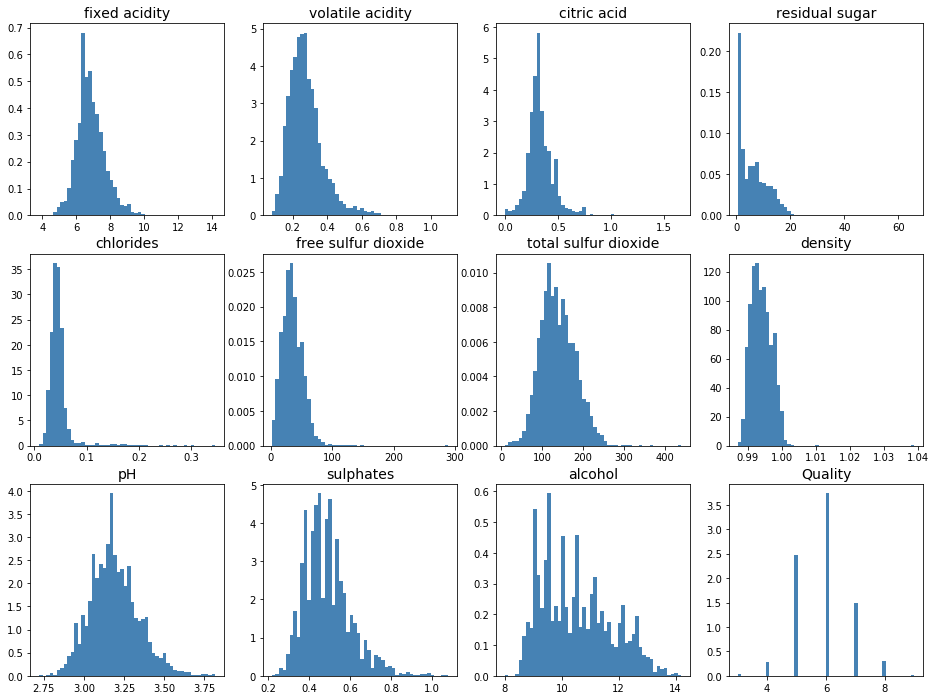

In [4]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue',
                normed=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

ax = fig.add_subplot(3,4, 12)
h = ax.hist(y, bins=50, color='steelblue',
            normed=True, edgecolor='none')
ax.set_title('Quality', fontsize=14)
plt.show()

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “sulphates” varie de 0 à 1 tandis que “total sulfur dioxide” varie de 0 à 440. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.

Nous allons commencer par transformer ce problème en un problème de classification : il s’agira de séparer les bons vins des vins médiocres :

In [5]:
y_class = np.where(y<6, 0, 1)

Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.
On paramètre 'random_state' avec la valeur du seed pour que la séparation des données soit fixe et reproductible.

In [6]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y_class,
                                    test_size=0.3, # 30% des données dans le jeu de test
                                     random_state = seed
                                    )

Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [7]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandeur similaires.

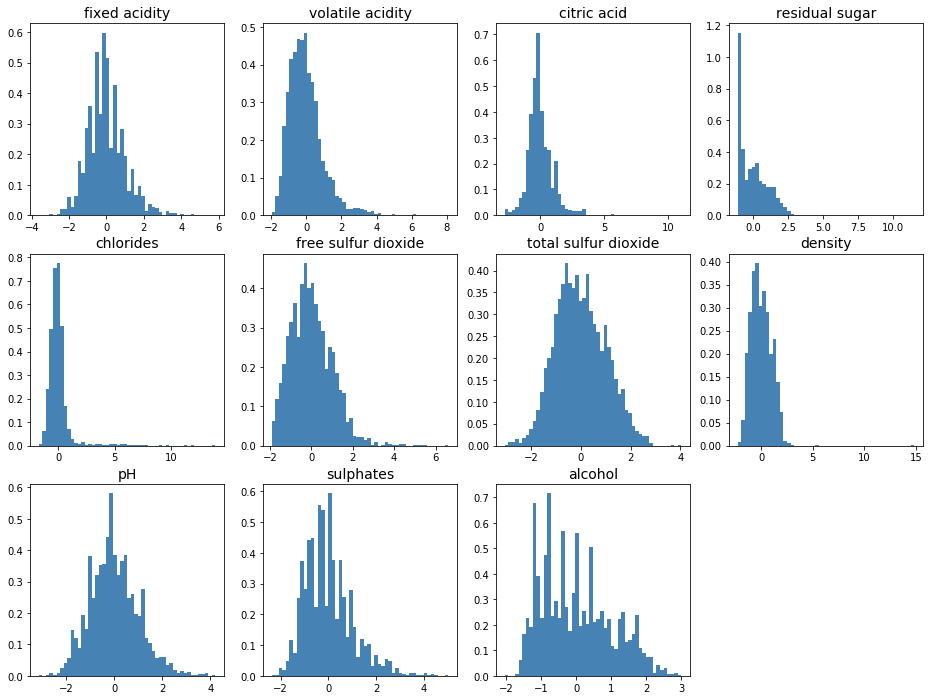

In [8]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue',
        normed=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

# Sélection de modèles avec GridSearchCV

On crée les 5 k-fold en utilisant la seed afin que ces folds soient reproductibles :

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for train_index, test_index in kf.split(X_train_std):
    print("TRAIN:", "taille", len(train_index), ", 5ers indices", train_index[0:5], 
          "|| TEST:", "taille", len(test_index), ", 5ers indices", test_index[0:5])

TRAIN: taille 2742 , 5ers indices [1 2 3 4 5] || TEST: taille 686 , 5ers indices [ 0 14 17 25 26]
TRAIN: taille 2742 , 5ers indices [0 1 2 3 4] || TEST: taille 686 , 5ers indices [ 7 12 22 29 41]
TRAIN: taille 2742 , 5ers indices [0 1 3 4 5] || TEST: taille 686 , 5ers indices [ 2  6  8 13 18]
TRAIN: taille 2743 , 5ers indices [0 1 2 4 6] || TEST: taille 685 , 5ers indices [ 3  5  9 10 15]
TRAIN: taille 2743 , 5ers indices [0 2 3 5 6] || TEST: taille 685 , 5ers indices [ 1  4 11 16 19]


Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [10]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # un classifieur kNN
                                    param_grid, # hyperparamètres à tester
                                    cv=kf, # folds pour la validation croisée
                                    scoring=score # score à optimiser
                                    )

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # score moyen
                                clf.cv_results_['std_test_score'], # écart-type du score
                                clf.cv_results_['params'] # valeur de l'hyperparamètre
                                ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
                                                mean, # score moyen
                                                std * 2, # barre d'erreur
                                                params # hyperparamètre
                                                ))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}
Résultats de la validation croisée :
	accuracy = 0.762 (+/-0.013) for {'n_neighbors': 3}
	accuracy = 0.766 (+/-0.015) for {'n_neighbors': 5}
	accuracy = 0.764 (+/-0.008) for {'n_neighbors': 7}
	accuracy = 0.757 (+/-0.019) for {'n_neighbors': 9}
	accuracy = 0.759 (+/-0.010) for {'n_neighbors': 11}
	accuracy = 0.761 (+/-0.011) for {'n_neighbors': 13}
	accuracy = 0.762 (+/-0.014) for {'n_neighbors': 15}


In [11]:
pd.DataFrame(clf.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,{'n_neighbors': 3},0.761669,4
1,{'n_neighbors': 5},0.765753,1
2,{'n_neighbors': 7},0.763711,2
3,{'n_neighbors': 9},0.756709,7
4,{'n_neighbors': 11},0.758751,6
5,{'n_neighbors': 13},0.761377,5
6,{'n_neighbors': 15},0.762252,3


La meilleure performance (~0.766) est ici atteinte avec 5 voisins.

Nous pouvons maintenant regarder la performance sur le jeu de test. GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement.

In [12]:
y_pred = clf.predict(X_test_std)
print("\nAccuracy score sur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))


Accuracy score sur le jeu de test : 0.770


# Sélection des modèles manuellement

On commence par créer la fonction qui va effectuer la validation croisée :

In [13]:
def cvf(X, y, n_neighbors, n_fold, verbose=False):
    """
    X : données 
    y : valeur à prédire 
    n_neighbors : liste des K à tester pour le K-NN
    n_fold : nombre de folds à créer
    verbose : False par défaut, permet d'afficher dees informations du code
    """
    
    # on recrée les folds. Etant donné que pour l'exercice on va utiliser n_fold = 5 comme dans la partie 1,
    # et qu'on utilise la même seed, on aura les mêmes folds que dans la partie 1.
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
    if verbose: 
        for train_index, test_index in kf.split(X):
            print("TRAIN:", "taille", len(train_index), ", 5ers indices", train_index[0:5], 
                  "|| TEST:", "taille", len(test_index), ", 5ers indices", test_index[0:5])
    
    # on initialise le tableau qui contiendra les différents résultats
    accuracy_mean = [] 
    
    # on boucle pour tester les différentes valeurs de K pour le KNN
    for kn in n_neighbors:
        if verbose: print("kn", kn)    
        knn = neighbors.KNeighborsClassifier(kn) # initialisation du classifieur
        
        accuracy = [] # initialisation d'une liste qui contiendra l'accuracy pour chaque k-fold et chaque knn
        
        # on boucle sur les différents folds
        for train_index, test_index in kf.split(X):
            if verbose: print("TRAIN:", "taille", len(train_index), ", 5ers indices", train_index[0:5], 
                      "|| TEST:", "taille", len(test_index), ", 5ers indices", test_index[0:5])
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
                        
            # on fit le knn sur le fold d'entrainement
            knn.fit(X_train, y_train)
            
            # on test l'accuracy sur le fold de test et on l'ajoute au tableau 'accuracy':
            accuracy.append([knn.score(X_test, y_test)])
        if verbose: print(np.mean(accuracy))
        
        # on aggrège les résultats en ne gardant que la moyenne des accuracy des différents folds pour chaque k
        accuracy_mean.append([kn, round(np.mean(accuracy), 3)])
    
    return accuracy_mean            

On fait tourner notre fonction avec les mêmes valeurs que celles utilisées pour le GridSearchCV :

In [14]:
n_neighbors = [3, 5, 7, 9, 11, 13, 15]
n_fold = 5

cvf = cvf(X_train_std, y_train, n_neighbors, n_fold, verbose=False)

On obtient le tableau des accuracy moyennes pour chaque K :

In [15]:
cvf_df = pd.DataFrame(cvf, columns=['knn', 'mean_accuracy'])
cvf_df

,knn,mean_accuracy
0,3,0.762
1,5,0.766
2,7,0.764
3,9,0.757
4,11,0.759
5,13,0.761
6,15,0.762


In [16]:
cvf_df[cvf_df['mean_accuracy'] == cvf_df['mean_accuracy'].max()]

,knn,mean_accuracy
1,5,0.766


Le K à sélectionner est donc 5, avec une accuracy moyenne de 0.766, ce qui correspond à ce que renvoyait GridSearchCV avec les mêmes données.

Nous pouvons maintenant regarder la performance sur le jeu de test. 

In [17]:
knn5 = neighbors.KNeighborsClassifier(5)
knn5.fit(X_train_std, y_train)
print("\nAccuracy score sur le jeu de test : %0.3f" % knn5.score(X_test_std, y_test))


Accuracy score sur le jeu de test : 0.770


On retrouve la même accuracy qu'avec le GridSearchCV.

# Evaluation de la classification knn

## Courbe ROC

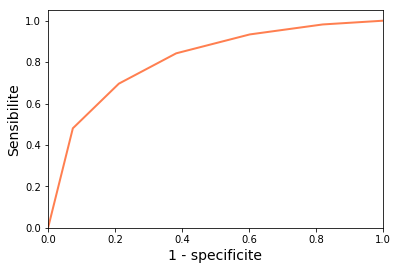

In [18]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)
plt.show()

Calculons l'aire sous la courbee ROC :

In [19]:
print("AUROC =", round(metrics.auc(fpr, tpr), 3))

AUROC = 0.812


Prenons l’exemple du vinho verde. Imaginons que l’algorithme doit être capable de détecter efficacement les vins de mauvaise qualité, qui ne seront pas ensuite examinés par un expert humain. On veut alors limiter le nombre de faux négatifs, pour limiter le nombre de rejets infondés. Fixons-nous un taux de faux négatifs tolérable (la proportion de positifs incorrectement prédits négatifs) de 5%. Cela équivaut à une sensibilité de 0.95 :

In [20]:
idx = np.min(np.where(tpr > 0.95)) # indice du premier seuil pour lequel
                                   # la sensibilité est supérieure à 0.95
print("Sensibilité : %.2f" % tpr[idx])
print("Spécificité : %.2f" % (1-fpr[idx]))
print("Seuil : %.2f" % thr[idx])

Sensibilité : 0.98
Spécificité : 0.18
Seuil : 0.20


Utiliser un seuil de 0.20 nous garantit une sensibilité de 0.98 et une spécificité de 0.18, soit un taux de faux positifs de… 82%.

## Evaluer en comparant avec des approches naïves

In [21]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.3, # 30% des données dans le jeu de test
                                     random_state = seed
                                    )
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

Entraînons un kNN avec k=11 sur ces données :

In [22]:
knn2 = neighbors.KNeighborsRegressor(n_neighbors=11)

knn2.fit(X_train_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=11, p=2,
          weights='uniform')

Et appliquons le pour prédire les étiquettes de notre jeu de test :

In [23]:
y_pred = knn2.predict(X_test_std)

Calculons la RMSE correspondante :

In [24]:
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.71


Valeurs prédites VS vraies valeurs :

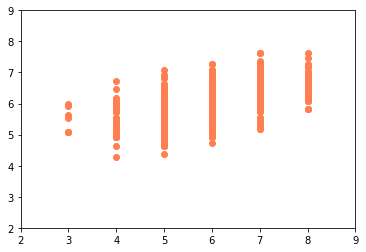

In [25]:
plt.scatter(y_test, y_pred, color='coral')
plt.axis([2, 9, 2, 9])
plt.show()

Comme nos étiquettes prennent des valeurs entières entre 3 et 8, nous avons beaucoup de points superposés aux même coordonnées. Pour mieux visualiser les données, nous pouvons utiliser comme marqueurs des cercles dont la taille est proportionnelle au nombre de points qui sont présents à ces coordonnées.

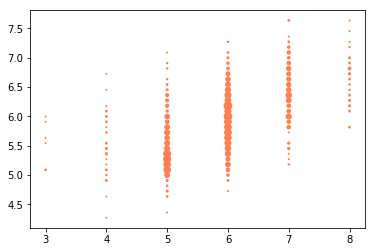

In [26]:
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter([k[0] for k in keys], # vraie valeur (abscisse)
            [k[1] for k in keys], # valeur predite (ordonnee)
            s=[sizes[k] for k in keys], # taille du marqueur
            color='coral')
plt.show()

On note ainsi une accumulation de prédictions correctes sur la diagonale. Néanmoins le modèle n'est pas très précis dans ses prédictions.

Pour mieux comprendre notre modèle, comparons-le à une première approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [27]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.shape)

Calculons la RMSE correspondante :

In [28]:
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_random)))

RMSE : 1.89


On obtient une RMSE bien supérieure à la RMSE obtenue par notre modèle kNN. Notre modèle a ainsi réussi à bien mieux apprendre qu'un modèle aléatoire.

Cependant, beaucoup de nos vins ont une note de 6, et beaucoup de nos prédictions sont autour de cette valeur. Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

Nous pouvons utiliser pour cela la fonction correspondante du module "dummy" de scikit-learn.

In [29]:
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)))

RMSE : 0.87


On obtient une RMSE légèrement supérieure à celle obtenue par le kNN. Le kNN a donc appris plus que la moyenne des étiquettes.